In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
#Loading data
DF = pd.read_csv("/content/drive/My Drive/Colab Notebooks/creditcard.csv")
DF.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [0]:
DF.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [0]:
DF.isna().sum()
#Not missing values, great data set

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

We define our targets (variable to be predicted) and predictors.

In [0]:
#Predictors. I get rid of the variable "Time" since is introducing an undesirable ordering among the data that will interfere 
#with the model.

X = DF.drop(columns=['Time','Class'])
#Target
Y = DF["Class"]

In [0]:
#we check the number of non_fraudulent transactions
len(Y[Y==0])

284315

In [0]:
#we check the number of fraudulent transactions
len(Y[Y==1])

492

We see that there is a huge disproportion among the number of fraudulent and non fraudulent transactions. We need to be careful with that. In order to deal with this anomaly we can resample several models.

In [0]:
#we take the dataframe with only fraudulent cases
DF_1 = DF[DF["Class"]==1]
#we take the dataframe with only non_fraudulent cases
DF_0 = DF[DF["Class"]==0]

#shuffle the data to avoid any possible biases
DF_0 = DF_0.sample(frac=1)
print(len(DF_1))
print(len(DF_0))

492
284315


## Resampling example
First I do an example of resampling constructing a dataframe with the same numbers of fraudulent and non-fraudulent classes. Later I explore further.


Example of resampling with the first 492  elements of the dataframe with non-fraudulent cases (DF_0). (same number of fraudulent cases).

In [0]:
#We take the first n elements with target class=0
n = 492
DF_0_sample= DF_0[:n]
#we take the data frame with only fraudulent cases
print(len(DF_0_sample))
DF_0_sample.head(3)

492


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
55531,46992.0,1.316852,-0.005343,-0.170504,-0.008041,-0.315895,-1.093268,0.161250,-0.155798,0.320260,-0.070149,-0.993658,-1.139702,-2.230982,0.863507,1.145043,0.372848,-0.248483,-0.558984,0.480399,-0.191100,-0.498278,-1.619495,0.167406,-0.170587,0.084074,0.660472,-0.118572,-0.004907,15.99,0
150582,93708.0,1.763900,-0.381389,-1.792586,0.690047,0.088524,-0.806915,0.061021,-0.223372,2.513225,-1.235154,0.146552,-3.045073,0.049350,0.301585,-0.639561,0.078297,1.861675,0.548701,-0.083996,-0.006345,-0.337626,-0.890560,0.121738,0.521493,-0.164540,-0.170444,-0.074870,0.000286,150.94,0
263203,160840.0,-1.152261,1.982299,-0.466253,0.988064,1.342300,-0.480894,1.257989,0.172360,-1.264842,-0.992355,-0.632807,0.151055,0.797225,-0.997914,-0.049889,-0.609520,1.476471,0.266747,0.725151,0.133806,-0.027537,0.084361,-0.457710,0.520457,1.284948,-0.202310,0.070736,0.070166,19.66,0


In [0]:
#Now, we concat the fraudulent and non-fraudulent (the resampled one) dataframes
DF_Sample = pd.concat([DF_1, DF_0_sample], axis=0)

#shuffle the data to avoid any possible bias again
DF_Sample= DF_Sample.sample(frac=1)

#Dataframe with the same number of fraudulent and non-fraudulent cases
print(len(DF_Sample))
DF_Sample.head(3)

984


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
15539,26931.0,-22.561699,13.208904,-24.643819,6.232532,-16.905611,-4.497439,-16.810184,14.955107,-3.871297,-8.581266,5.256988,-7.393615,0.538801,-7.577552,-0.030726,-6.454783,-12.845657,-4.865918,1.062442,1.621444,1.765987,-1.635517,-0.998317,0.138972,1.559350,-0.222125,1.504425,0.445920,99.99,1
225014,144062.0,1.652434,-0.364537,-2.268888,1.240446,0.581917,-0.985236,1.027778,-0.423691,-0.377995,0.477016,0.549556,0.433788,-0.699449,1.188587,-0.462790,-0.144316,-0.738663,0.299118,-0.039118,0.122314,0.324033,0.524414,-0.292956,-0.329372,0.480449,-0.435680,-0.085100,-0.044842,214.17,0
31318,36317.0,-1.960513,-0.515143,2.604563,1.826371,1.549287,-1.285284,-0.524444,0.259807,-0.918141,0.055344,-0.940679,-0.665926,-0.563228,0.114234,0.326352,1.060995,-0.900165,0.320540,-1.663689,0.278458,0.321912,0.292040,-0.039732,0.345992,0.494484,0.020353,-0.034327,0.103002,10.62,0


In [0]:
#Predictors for the sampled dataframe
X_Sample = DF_Sample.drop(columns=['Time','Class'])

#Target for this sample
Y_Sample = DF_Sample["Class"]

#### We split in train and test and fix seed with random_state. We could do some cross validation since the resampled datafrale is not too big. However in the following we will have bigger datasets and the results are similar hence  due to the shuffling the train and validation partitions surely are well distributed.

In [0]:
from sklearn.model_selection import train_test_split
X_Sample_train, X_Sample_val, y_Sample_train, y_Sample_val = train_test_split(X_Sample, Y_Sample, test_size = 0.2, random_state = 42)

Since this is a classification problem obviously we  need a classification algorithm.

I choose Random Forest classifier (RF). Perhaps in the case where the data is imbalanced a logistic regression might work better since the weights would remain the same (the intercept would be biased but that can be fixed), however, since I am doing a resampling the two classes have the same predominance so we should not worry about a skewed result. Thus a model like RF might work better in this case since it has a bigger power of generalization. For the next cases where I am going to introduce some asymmetry among the classes we will use an adequate metric that indicates correctly the performance of the model independently of such an asymmetry.

No neuronal network intended for this data set since the complexity is not too large.

In [0]:
from sklearn.ensemble import RandomForestClassifier
RF_Sample = RandomForestClassifier()
RF_Sample.fit(X_Sample_train, y_Sample_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### In order to see how good our model performs I choose as a metric a ROC curve since it takes into account True Positive Rate and False Positive Rate making it invariant to the proportion of the clases. 

####  Again, in this particular model, since is resampled, the acuracy might be sufficient and the ROC curve not necessary since the proportion of 0's and 1's is the same, nevertheless, in further steps is going to be important.


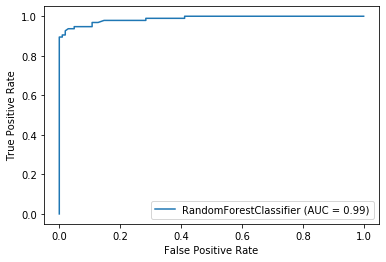

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import  plot_roc_curve
metric = plot_roc_curve(RF_Sample, X_Sample_val, y_Sample_val)
plt.show()
#The model seems to work well

#### We have a great amount of area under the curve so the model works well.

#### Now I check the accuracy, in principle this metric is useful now because in this step the sample is well distributed in the classes. However is not a good metric for imbalanced data models unless you have some extra info like a ROC curve.

In [0]:
#train set score
RF_Sample.score(X_Sample_train,y_Sample_train)

1.0

In [0]:
#validation data score
RF_Sample.score(X_Sample_val,y_Sample_val)

0.9441624365482234

####  Now we check the accuracy of this model on the remaining data which is only composed of classes=0.

In [0]:
Test_data = DF_0[n:]
len(Test_data)

283823

In [0]:
X_test = Test_data.drop(columns=['Time','Class'])
Y_test = Test_data["Class"]
RF_Sample.score(X_test,Y_test)

0.9664368285868306

# Several Resamplings

#### Now I resample the model incorporating a larger quantity of data (0's) and not a 50/50 distribution of 1's and 0's.

#### I will contrast resampled models of 492 0's, like the one already done, and 1000, 5000, 10000, 100000 and 200000 0's.

#### All the time compared agains 492 1's, the maximum number of fraudulent cases at hand.

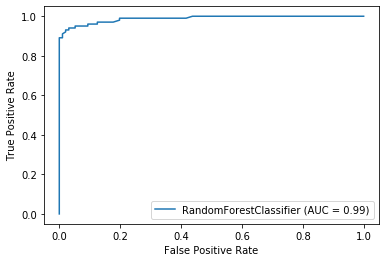

492 0's exemplars taken into account. The scores for this sample are:
train score 1.0
validation score 0.949238578680203
test score 0.9731389479978193


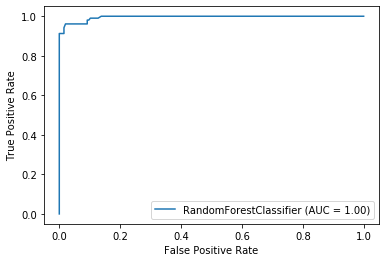

1000 0's exemplars taken into account. The scores for this sample are:
train score 1.0
validation score 0.959866220735786
test score 0.9931589961838102


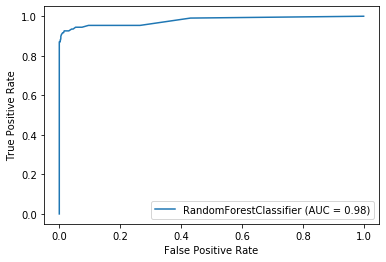

5000 0's exemplars taken into account. The scores for this sample are:
train score 1.0
validation score 0.9872611464968153
test score 0.9991488314017902


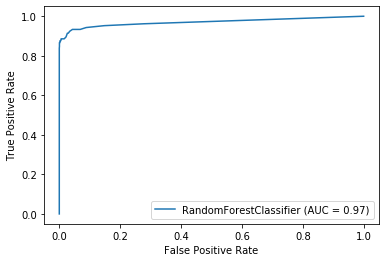

10000 0's exemplars taken into account. The scores for this sample are:
train score 1.0
validation score 0.9923773225345403
test score 0.9993282099080245


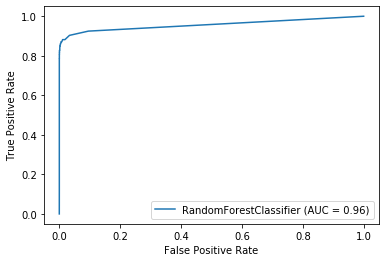

50000 0's exemplars taken into account. The scores for this sample are:
train score 1.0
validation score 0.9979205861966531
test score 0.9997643458839667


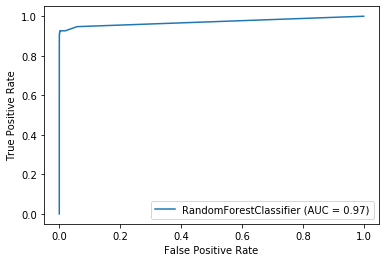

100000 0's exemplars taken into account. The scores for this sample are:
train score 0.9999875611060665
validation score 0.9992536942136425
test score 0.9998698626523398


In [0]:
number_of_zeros_taken=[492,1000,5000,10000, 50000, 100000]
for i in range(len(number_of_zeros_taken)):
  
  n = number_of_zeros_taken[i]
  
  #We take the first n elements with target class=0
  DF_0_sample= DF_0[:n]

  #Now, we concat the dataframes. DF_1 dataframe with only 1's.
  DF_Sample = pd.concat([DF_1, DF_0_sample], axis=0)

  #shuffle the data
  DF_Sample= DF_Sample.sample(frac=1)

  #Predictors for this sample
  X_Sample = DF_Sample.drop(columns=['Time', 'Class'])

  #Target for this sample
  Y_Sample = DF_Sample["Class"]

  #Train Validation
  X_Sample_train, X_Sample_val, y_Sample_train, y_Sample_val = train_test_split(X_Sample, Y_Sample, test_size = 0.2, random_state=42)

  #Choice of model
  RF_Sample = RandomForestClassifier()
  RF_Sample.fit(X_Sample_train, y_Sample_train)

  #Metric
  metric = plot_roc_curve(RF_Sample, X_Sample_val, y_Sample_val)
  
  plt.show()

  print(n, "0's exemplars taken into account. The scores for this sample are:")
  
  #train set score
  print("train score",RF_Sample.score(X_Sample_train,y_Sample_train))

  #validation data score
  print("validation score", RF_Sample.score(X_Sample_val,y_Sample_val))

  #Test data

  Test_data = DF_0[n:]

  #Test variables
  X_test = DF_0.drop(columns=['Time', 'Class'])
  Y_test = DF_0["Class"]

  #Test score
  print("test score", RF_Sample.score(X_test,Y_test))

#### As it is expected the more 0's we involve in the design of our model there is a trend in the area under the curve (AUC) to decrease since the model gets skewed towars the 0 Class.

#### Nevertheless, important is to remark that sometimes the best resampled model is not necessarily the 50/50 model given that sometimes some reasonable extra amount of information (even if it skews a bit) may provide information that makes our model to generalize better.

## We see that the models (for this partition) that better generalize for the two classes are the one with 492 0's (AUC=.99) and the one with 1000 0's (AUC=1.0) Being the scores of the latter the most trustworthy.


